In [8]:
#Physically meaningful polymer model. Possibly better than previous heuristics.

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class PolymerMotion:
    def __init__(self, num_particles, spring_constants, rest_lengths=None, mass=1.0, dt=0.01, total_time=10):
        self.num_particles = num_particles
        self.k = np.asarray(spring_constants)

        if self.k.shape != (num_particles, num_particles):
            raise ValueError("spring_constants must be a symmetric (N x N) matrix")

        self.rest_lengths = np.ones((num_particles, num_particles)) if rest_lengths is None else np.asarray(rest_lengths)
        if self.rest_lengths.shape != (num_particles, num_particles):
            raise ValueError("rest_lengths must be a (N x N) matrix")

        self.mass = np.full(num_particles, mass) if np.isscalar(mass) else np.asarray(mass)
        if self.mass.shape != (num_particles,):
            raise ValueError("mass must be scalar or 1D array of shape (num_particles,)")

        self.dt = dt
        self.total_time = total_time
        self.time_steps = int(total_time / dt)

        np.random.seed(42)
        self.positions = np.random.rand(num_particles, 2)
        self.velocities = np.zeros((num_particles, 2))
        self.trajectory = np.zeros((self.time_steps, num_particles, 2))

    def forces(self, positions):
        """Compute spring forces between particles based on Hooke's law with rest lengths."""
        F = np.zeros((self.num_particles, 2))
        for i in range(self.num_particles):
            for j in range(i + 1, self.num_particles):
                displacement = positions[j] - positions[i]
                distance = np.linalg.norm(displacement)
                if distance > 1e-8:
                    direction = displacement / distance
                    extension = distance - self.rest_lengths[i, j]
                    force = self.k[i, j] * extension * direction
                    F[i] += force
                    F[j] -= force
        return F

    def motion_equations(self, y, t):
        pos = y[:self.num_particles * 2].reshape((self.num_particles, 2))
        vel = y[self.num_particles * 2:].reshape((self.num_particles, 2))

        F = self.forces(pos)
        damping = -0.1 * vel  # simple drag

        dydt = np.zeros_like(y)
        dydt[:self.num_particles * 2] = vel.flatten()
        dydt[self.num_particles * 2:] = ((F + damping) / self.mass[:, None]).flatten()
        return dydt

    def simulate(self):
        y0 = np.hstack((self.positions.flatten(), self.velocities.flatten()))
        t = np.linspace(0, self.total_time, self.time_steps)
        sol = odeint(self.motion_equations, y0, t)
        self.trajectory = sol[:, :self.num_particles * 2].reshape((-1, self.num_particles, 2))
        return self.trajectory

    def generate_transition_matrix(self):
        """
        Construct a transition matrix from displacement similarity over time.
        """
        cumulative_displacements = np.zeros((self.num_particles, self.num_particles))

        for t in range(1, self.time_steps):
            disp = np.linalg.norm(
                self.trajectory[t][:, None, :] - self.trajectory[t - 1][None, :, :],
                axis=2
            )
            cumulative_displacements += disp

        with np.errstate(divide='ignore'):
            similarity = np.where(cumulative_displacements > 0,
                                  1.0 / cumulative_displacements,
                                  0.0)

        row_sums = similarity.sum(axis=1, keepdims=True)
        transition_matrix = np.divide(similarity, row_sums,
                                      out=np.full_like(similarity, 1.0 / self.num_particles),
                                      where=row_sums > 0)

        return transition_matrix

    def plot_trajectories(self):
        time = np.linspace(0, self.total_time, self.time_steps)
        plt.figure(figsize=(12, 6))
        for i in range(self.num_particles):
            plt.plot(time, self.trajectory[:, i, 0], label=f'Particle {i+1} X', linestyle='-')
            plt.plot(time, self.trajectory[:, i, 1], label=f'Particle {i+1} Y', linestyle='--')
        plt.title('Particle Trajectories Over Time')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

def generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix):
    """
    Generate correlated random walks based on polymer-derived transition matrix and target correlation.

    Args:
        polymer_model (PolymerMotion): Simulated instance of PolymerMotion.
        num_walks (int): Number of walks to generate.
        num_steps (int): Steps per walk.
        target_corr_matrix (ndarray): Target correlation between walks (must be PSD).

    Returns:
        ndarray: Correlated discrete random walks (num_walks x num_steps).
    """
    assert np.all(np.linalg.eigvals(target_corr_matrix) > 0), "Correlation matrix must be positive definite."

    # Cholesky decomposition
    L = np.linalg.cholesky(target_corr_matrix)

    # Build transition matrix from dynamics
    transition_matrix = polymer_model.generate_transition_matrix()

    # Generate uncorrelated (independent) walks
    independent_walks = np.zeros((num_walks, num_steps))
    for i in range(num_walks):
        state = np.random.choice(polymer_model.num_particles)
        walk = [state]
        for _ in range(num_steps - 1):
            state = np.random.choice(polymer_model.num_particles, p=transition_matrix[state])
            walk.append(state)
        independent_walks[i] = walk

    # Apply correlation structure
    correlated_walks = L @ independent_walks
    return correlated_walks

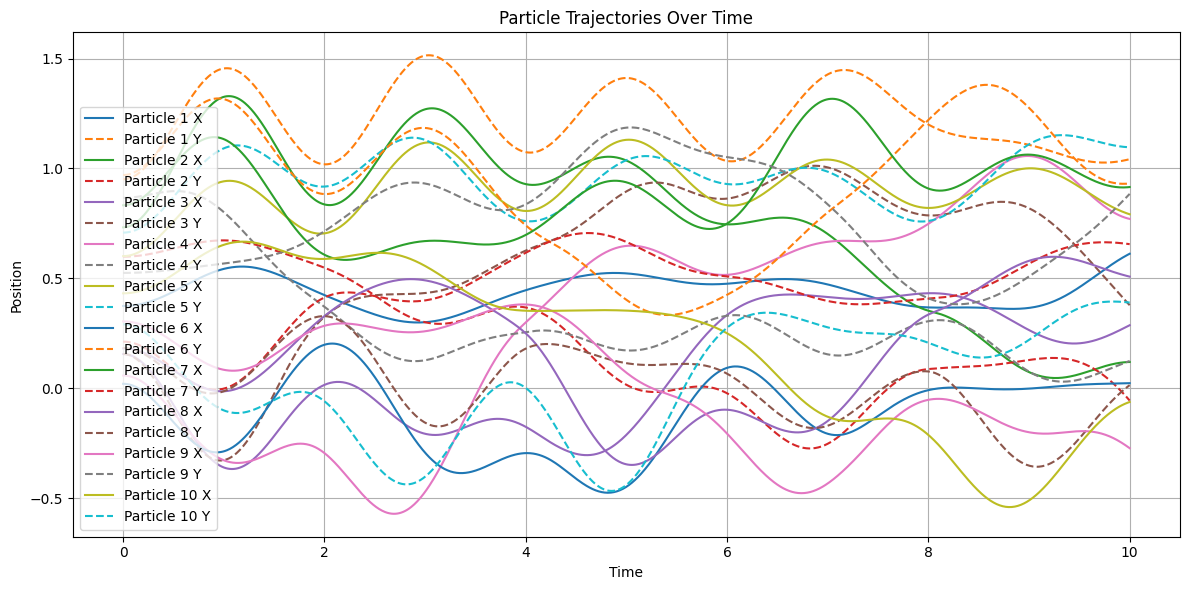

In [9]:
num_particles = 10

# Create a symmetric matrix with ones (and zeros on the diagonal)
spring_constants = np.ones((num_particles, num_particles)) - np.eye(num_particles)

# Optional: Set rest lengths to 1.0 for all pairs
rest_lengths = np.ones((num_particles, num_particles))

polymer_model = PolymerMotion(num_particles, spring_constants, rest_lengths)
trajectory = polymer_model.simulate()
polymer_model.plot_trajectories()

In [10]:
#Generate a correlation matrix from Higham's algorithm
import numpy as np
from scipy.linalg import eigh

# Step 1: Generate a random matrix and symmetrize it
def generate_random_correlation_matrix(n):
    # Generate a random matrix
    A = np.random.rand(n, n)

    # Symmetrize the matrix
    A = (A + A.T) / 2

    # Step 2: Force diagonal elements to 1 (for correlation matrix)
    np.fill_diagonal(A, 1)

    return A

# Step 3: Apply Higham's algorithm to ensure the matrix is PSD
def higham_psd(matrix, tol=1e-8):
    """
    Adjusts the matrix to be positive semi-definite using Higham's algorithm.
    Parameters:
    - matrix: Input matrix to be corrected.
    - tol: Tolerance for eigenvalue correction.
    """
    # Eigen decomposition (guaranteed to work for symmetric matrices)
    eigvals, eigvecs = eigh(matrix)

    # Replace negative eigenvalues or those below tolerance with zeros (for PSD)
    eigvals = np.clip(eigvals, tol, None)

    # Reconstruct the matrix from modified eigenvalues and eigenvectors
    psd_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # Step 4: Rescale to ensure diagonals are exactly 1
    D = np.sqrt(np.diag(psd_matrix))
    psd_matrix = psd_matrix / np.outer(D, D)

    # Fix numerical issues with diagonal exactly being 1
    np.fill_diagonal(psd_matrix, 1)
    return psd_matrix

In [11]:
# Step 5: Generate a random matrix and make it a PSD correlation matrix
n = 1000  # Number of variables
random_matrix = generate_random_correlation_matrix(n)
psd_matrix = higham_psd(random_matrix)

# Example of generating correlated random walks
target_corr_matrix = psd_matrix

In [12]:
transition_matrix = polymer_model.generate_transition_matrix()
num_walks = 1000
num_steps = 5000
random_walks = generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix)

In [13]:
#Function to rescale the walks

def rescale_to_limits(data, lower_limit, upper_limit):

    min_val = np.min(data)
    max_val = np.max(data)

    # Rescale using min-max normalization
    rescaled_data = (data - min_val) / (max_val - min_val)  # Normalize to [0, 1]
    rescaled_data = rescaled_data * (upper_limit - lower_limit) + lower_limit  # Scale to [lower_limit, upper_limit]

    return rescaled_data

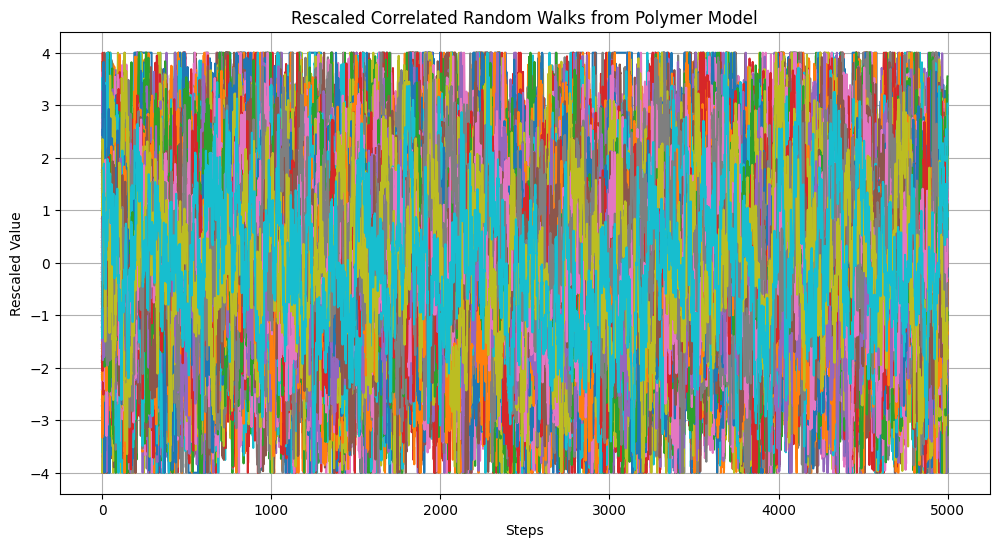

In [14]:
# Rescale each random walk to the range [lower_limit, upper_limit]
lower_limit = -4.0  # Specify the lower limit
upper_limit = 4.0  # Specify the upper limit

plt.figure(figsize=(12, 6))
r=[]

for i in range(random_walks.shape[0]):
    rescaled_walk = rescale_to_limits(random_walks[i], lower_limit, upper_limit)
    r.append(rescaled_walk)
    plt.plot(rescaled_walk, label=f'Walk {i+1}')

plt.title('Rescaled Correlated Random Walks from Polymer Model')
plt.xlabel('Steps')
plt.ylabel('Rescaled Value')
plt.grid()
plt.show()